In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from mpl_toolkits.mplot3d import Axes3D


In [12]:
def regressionXG(df: pd.DataFrame, Y: pd.DataFrame, 
                 lr: float, md: int,
                 alpha: int, iterations: int, f1: list,
                 f2: list,  is_cal_dataset: bool):
    
    X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.2, random_state=104639)

    lossFunc = 'mean_absolute_error'
    xg_reg = xgb.XGBRegressor(objective ='reg:pseudohubererror', colsample_bytree = 0.3, learning_rate = lr,
                    max_depth = md  , alpha = alpha, n_estimators = iterations, eval_metric=mean_absolute_error)

    evalset = [(X_train, y_train), (X_test, y_test)]
    xg_reg.fit(X_train, y_train, eval_set=evalset)

    output = xg_reg.evals_result()

    plt.figure()
    plt.plot(output['validation_0'][lossFunc], label='train')
    plt.plot(output['validation_1'][lossFunc], label='test')
    plt.title("Training and Test Error")
    plt.xlabel("Iterations M")
    plt.ylabel("Error")
    plt.ylim([0, 1])
    plt.legend()
    
    sorted_features = [x for _, x in sorted(zip(xg_reg.feature_importances_, X_train.columns.values), reverse=True)]
    importance = sorted(xg_reg.feature_importances_, reverse=True)
    importance = importance / max(importance) * 100
    plt.figure()
    plt.barh(range(len(xg_reg.feature_importances_)), importance)
    plt.xlabel("Relative Importance")
    plt.yticks(range(len(xg_reg.feature_importances_)), labels = sorted_features)

    fig, ax = plt.subplots(2, 2, figsize = (10, 10))
    PartialDependenceDisplay.from_estimator(xg_reg, X_train, f1, ax = ax)

    if is_cal_dataset:                                    
        ax[0,0].set_ylim([-.5, 2])
        ax[0,1].set_ylim([-1, 1.5])
        ax[1,0].set_ylim([-1, 1])
        ax[1,1].set_ylim([-1, 1.5])
        
        idx = np.linspace(-1, 1.5, 6) 
        ax[0,1].set_yticks(idx, labels = idx)
        ax[1,1].set_yticks(idx, labels = idx)


    fig = plt.figure()

    pdp = partial_dependence(xg_reg, X_train, features=f2,
                                   grid_resolution=20, kind='average')
    
    averages = pdp['average']
    axes = pdp['values']
    XX, YY = np.meshgrid(axes[0], axes[1])
    Z = averages[0].T 
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                        cmap=plt.cm.BuPu, edgecolor='k')
    ax.set_ylim(YY.max(), YY.min())
    ax.set_xlabel(f2[0])
    ax.set_ylabel(f2[1])
    ax.set_zlabel('Partial dependence')
    ax.view_init(elev=22, azim=122)
    plt.colorbar(surf)
    plt.subplots_adjust(top=0.9)

    plt.show()


[0]	validation_0-mphe:0.36086	validation_0-mean_absolute_error:0.82446	validation_1-mphe:0.36513	validation_1-mean_absolute_error:0.82901
[1]	validation_0-mphe:0.34089	validation_0-mean_absolute_error:0.79332	validation_1-mphe:0.34571	validation_1-mean_absolute_error:0.79905
[2]	validation_0-mphe:0.32413	validation_0-mean_absolute_error:0.76684	validation_1-mphe:0.32873	validation_1-mean_absolute_error:0.77245
[3]	validation_0-mphe:0.27700	validation_0-mean_absolute_error:0.69913	validation_1-mphe:0.28223	validation_1-mean_absolute_error:0.70589
[4]	validation_0-mphe:0.24642	validation_0-mean_absolute_error:0.64988	validation_1-mphe:0.25190	validation_1-mean_absolute_error:0.65727
[5]	validation_0-mphe:0.23860	validation_0-mean_absolute_error:0.63502	validation_1-mphe:0.24464	validation_1-mean_absolute_error:0.64319
[6]	validation_0-mphe:0.22063	validation_0-mean_absolute_error:0.60347	validation_1-mphe:0.22689	validation_1-mean_absolute_error:0.61254
[7]	validation_0-mphe:0.21308	vali

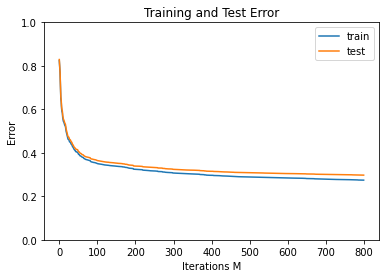

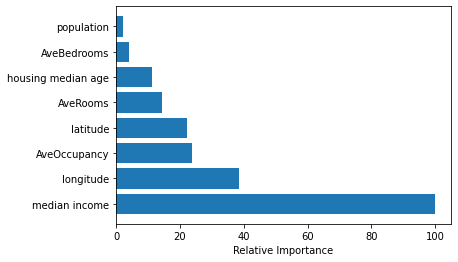

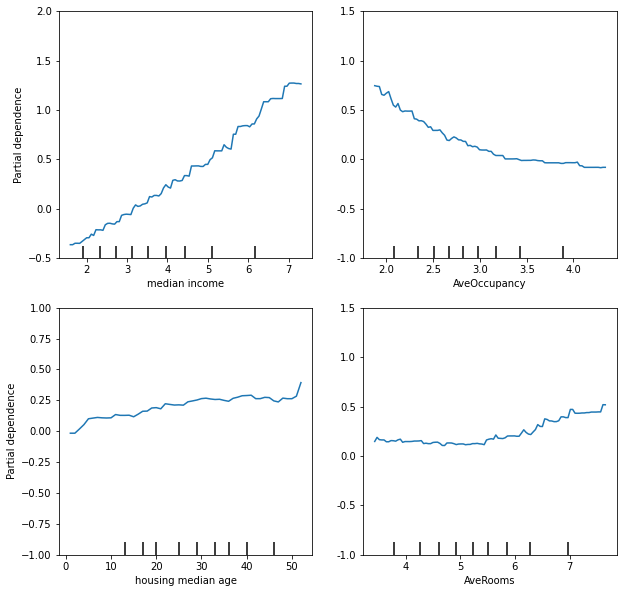

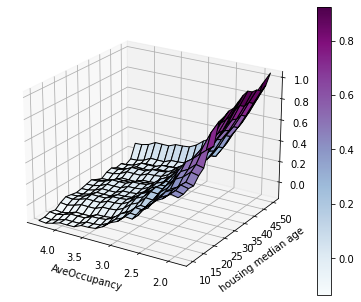

In [19]:
labels = ["median house value", "median income", "housing median age",
        "total rooms", "total bedrooms", "population", "households",
        "latitude", "longitude"]
df = pd.read_csv('cadata.txt', delim_whitespace=True,
                header=None, engine='python', names = labels)

df["AveOccupancy"] = df["population"] / df["households"]
df["AveRooms"] = df["total rooms"] / df["households"]
df["AveBedrooms"] = df["total bedrooms"] / df["households"]
df.drop(["total rooms", "total bedrooms", "households"], axis=1, inplace=True)
Y = df["median house value"].to_frame()
Y = (Y - 180000) / Y.std()
df = df.drop("median house value", axis=1)

regressionXG(df, Y, 0.1, 3, 5, 800, 
            ['median income', 'AveOccupancy', 'housing median age', 'AveRooms'],
            ['AveOccupancy', 'housing median age'], True)

[0]	validation_0-mphe:0.43334	validation_0-mean_absolute_error:1.02230	validation_1-mphe:0.43021	validation_1-mean_absolute_error:1.01904
[1]	validation_0-mphe:0.40923	validation_0-mean_absolute_error:0.98920	validation_1-mphe:0.40645	validation_1-mean_absolute_error:0.98573
[2]	validation_0-mphe:0.37553	validation_0-mean_absolute_error:0.93703	validation_1-mphe:0.37331	validation_1-mean_absolute_error:0.93453
[3]	validation_0-mphe:0.35127	validation_0-mean_absolute_error:0.89536	validation_1-mphe:0.34856	validation_1-mean_absolute_error:0.89187
[4]	validation_0-mphe:0.33397	validation_0-mean_absolute_error:0.86632	validation_1-mphe:0.33274	validation_1-mean_absolute_error:0.86305
[5]	validation_0-mphe:0.32301	validation_0-mean_absolute_error:0.84630	validation_1-mphe:0.32049	validation_1-mean_absolute_error:0.84004
[6]	validation_0-mphe:0.24259	validation_0-mean_absolute_error:0.71310	validation_1-mphe:0.23984	validation_1-mean_absolute_error:0.70672
[7]	validation_0-mphe:0.23619	vali

/home/ari/.local/lib/python3.8/site-packages/sklearn/inspection/_partial_dependence.py:154: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_eval.iloc[:, variable] = new_values[i]


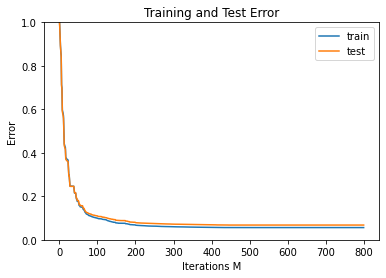

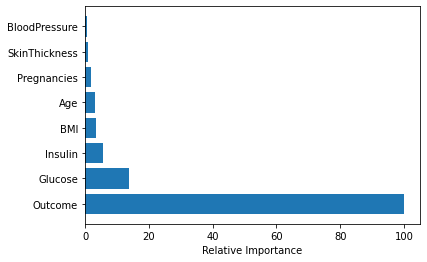

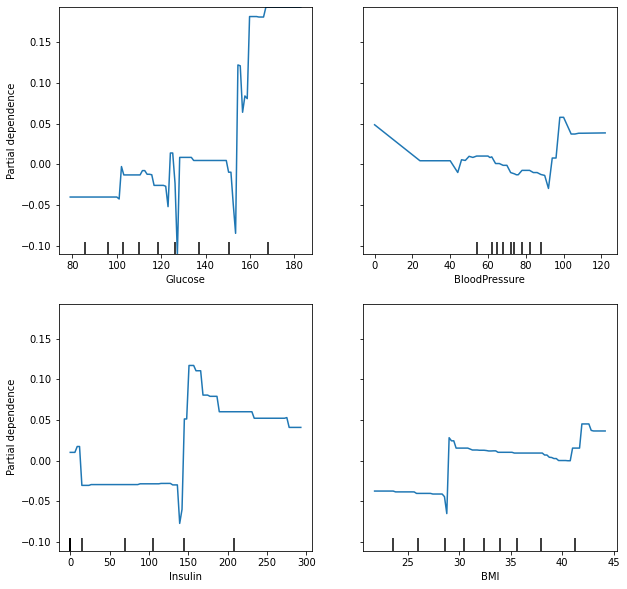

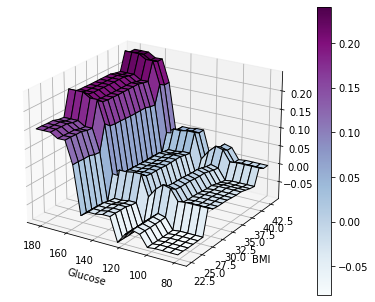

In [18]:
# Second dataset: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
indian_df = pd.read_csv("diabetes.csv")
indian_df.drop(["DiabetesPedigreeFunction"], axis=1, inplace=True)
indian_df = indian_df.fillna(0)

Y2 = indian_df["Outcome"].to_frame()
Y2 = (Y2 - Y2.mean()) / Y2.std()

regressionXG(indian_df, Y2, 0.1, 3, 5, 800,
                ["Glucose","BloodPressure","Insulin","BMI"],
                ["Glucose", "BMI"], False)